In [1]:
import sys
sys.version
!lscpu
!pwd

Architecture:        ppc64le
Byte Order:          Little Endian
CPU(s):              128
On-line CPU(s) list: 0-127
Thread(s) per core:  4
Core(s) per socket:  16
Socket(s):           2
NUMA node(s):        6
Model:               2.3 (pvr 004e 1203)
Model name:          POWER9, altivec supported
CPU max MHz:         3800.0000
CPU min MHz:         2300.0000
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            10240K
NUMA node0 CPU(s):   0-63
NUMA node8 CPU(s):   64-127
NUMA node252 CPU(s): 
NUMA node253 CPU(s): 
NUMA node254 CPU(s): 
NUMA node255 CPU(s): 
/home/kieffer/workspace/c-blosc2


In [10]:
import numpy
import os
os.environ["OMP_NUM_THREADS"] = "1"
from ctypes import *
import time
import bitshuffle
from math import ceil
from collections import OrderedDict, namedtuple
Result = namedtuple("Res", "bitshuffle_SSE2 bitunshuffle_SSE2 bitshuffle_VSX bitunshuffle_VSX")
%matplotlib nbagg
from matplotlib.pylab import subplots
import gc
gc.disable()

In [11]:
blosc2_ref = cdll.LoadLibrary("/home/kieffer/workspace/c-blosc2/libblosc2.so.2.0.0")
blosc2_dev = cdll.LoadLibrary("/home/kieffer/workspace/c-blosc2/build_dev/blosc/libblosc2.so.2.0.0")
blosc2_dev.shuffle.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_dev.unshuffle.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_dev.shuffle_generic.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_dev.shuffle_generic.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_dev.shuffle_altivec.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_dev.shuffle_altivec.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_ref.shuffle.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_ref.unshuffle.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_ref.shuffle_generic.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_ref.shuffle_generic.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_ref.shuffle_altivec.argtypes = [c_int32, c_int32, c_void_p, c_void_p]
blosc2_ref.shuffle_altivec.argtypes = [c_int32, c_int32, c_void_p, c_void_p]

#blosc2_ref.bshuf_trans_bit_elem_scal.argtypes = [c_void_p, c_void_p, c_int32, c_int32, c_void_p]
#blosc2_ref.bshuf_untrans_bit_elem_scal.argtypes = [c_void_p, c_void_p, c_int32, c_int32, c_void_p]
#blosc2_ref.bshuf_trans_bit_elem_altivec.argtypes = [c_void_p, c_void_p, c_int32, c_int32, c_void_p]
#blosc2_ref.bshuf_untrans_bit_elem_altivec.argtypes = [c_void_p, c_void_p, c_int32, c_int32, c_void_p]
blosc2_dev.bshuf_trans_bit_elem_scal.argtypes = [c_void_p, c_void_p, c_int32, c_int32, c_void_p]
blosc2_dev.bshuf_untrans_bit_elem_scal.argtypes = [c_void_p, c_void_p, c_int32, c_int32, c_void_p]
blosc2_dev.bshuf_trans_bit_elem_altivec.argtypes = [c_void_p, c_void_p, c_int32, c_int32, c_void_p]
blosc2_dev.bshuf_untrans_bit_elem_altivec.argtypes = [c_void_p, c_void_p, c_int32, c_int32, c_void_p]
blosc2_dev.bitshuffle1_altivec.argtypes = [c_void_p, c_void_p, c_size_t, c_size_t]
blosc2_dev.bitunshuffle1_altivec.argtypes = [c_void_p, c_void_p, c_size_t, c_size_t]
blosc2_dev.bshuf_trans_bit_byte_altivec.argtypes = [c_void_p, c_void_p, c_size_t, c_size_t]

In [12]:
def benchmark_bitshuffle_altivec(dtype="uint8", minsize=8, maxsize=25):
    print("Benchmarking bitshuffle altivec")
    results = OrderedDict()
    dtype = numpy.dtype(dtype)
    for i in range(minsize, maxsize):
        size = 1<<i
        if i>19:
            key = "%iM"%(1<<(i-20))
        elif i>9:
            key = "%ik"%(1<<(i-10))
        else:
            key = str(size)
        print(key, size)
        inp = numpy.random.randint(0, 255, size=size).astype(dtype)
        tmp = numpy.empty_like(inp)
        out = numpy.empty_like(inp)
        temp = numpy.empty_like(inp)
        
        blosc2_dev.bitshuffle1_altivec(inp.ctypes.data, tmp.ctypes.data, inp.size, 1)                                                                                                                   
        f=blosc2_dev.bshuf_trans_bit_byte_altivec(inp.ctypes.data, out.ctypes.data, inp.size, 1)
        assert abs(out-tmp).sum() == 0
        blosc2_dev.bitunshuffle1_altivec(tmp.ctypes.data, out.ctypes.data, inp.size, 1)
        assert abs(out-inp).sum() == 0
        blosc2_dev.bshuf_untrans_bit_elem_altivec(tmp.ctypes.data, out.ctypes.data, inp.size, 1, temp.ctypes.data)
        assert abs(out-inp).sum() == 0
        globals()["inp"] = inp
        globals()["tmp"] = tmp
        globals()["out"] = out
        globals()["temp"] = temp
        
        a = %timeit -o blosc2_dev.bshuf_trans_bit_byte_altivec(inp.ctypes.data, out.ctypes.data, inp.size, 1)      
        b = %timeit -o blosc2_dev.bshuf_untrans_bit_elem_altivec(tmp.ctypes.data, out.ctypes.data, inp.size, 1, temp.ctypes.data)         
        c = %timeit -o blosc2_dev.bitshuffle1_altivec(inp.ctypes.data, tmp.ctypes.data, inp.size, 1)
        d = %timeit -o blosc2_dev.bitunshuffle1_altivec(tmp.ctypes.data, out.ctypes.data, inp.size, 1)
        results[key] = Result(inp.nbytes/a.best/1e9, 
                              inp.nbytes/b.best/1e9, 
                              inp.nbytes/c.best/1e9,
                              inp.nbytes/d.best/1e9,
                             )
    return results

In [13]:
timing_bsa = benchmark_bitshuffle_altivec()

Benchmarking bitshuffle altivec
256 256
39.1 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
57.7 µs ± 920 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.4 µs ± 802 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.9 µs ± 965 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
512 512
40.1 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
58.2 µs ± 777 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.8 µs ± 399 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
42.4 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1k 1024
39.5 µs ± 953 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
57.8 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.1 µs ± 753 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.5 µs ± 906 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2k 2048
40.1 µs ± 836 ns per loop (mean ± std. dev. of 7 runs, 1

<IPython.core.display.Javascript object>


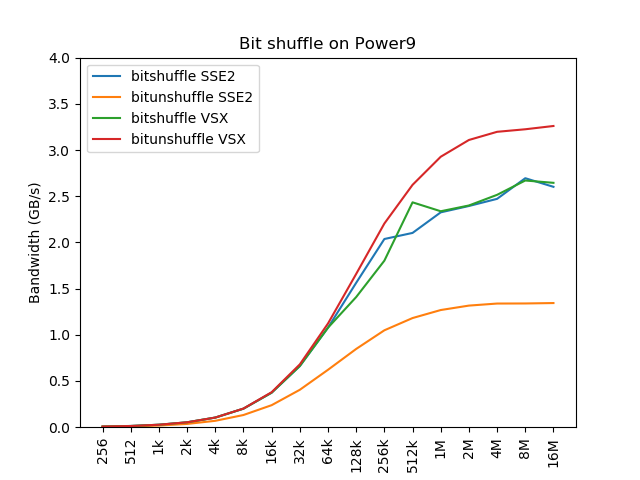

In [14]:
fig,ax = subplots()
ax.plot([i.bitshuffle_SSE2 for i in timing_bsa.values()], label="bitshuffle SSE2")
ax.plot([i.bitunshuffle_SSE2 for i in timing_bsa.values()], label="bitunshuffle SSE2")
ax.plot([i.bitshuffle_VSX for i in timing_bsa.values()], label="bitshuffle VSX")
ax.plot([i.bitunshuffle_VSX for i in timing_bsa.values()], label="bitunshuffle VSX")

ax.legend()
ax.set_title("Bit shuffle on Power9")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(timing_bsa)))
ax.set_xticklabels(list(timing_bsa.keys()), rotation='vertical')
ax.set_ylim((0, 4))
fig.savefig("bitshuffle_altivec_8bits.svg", transparent=True)

<IPython.core.display.Javascript object>


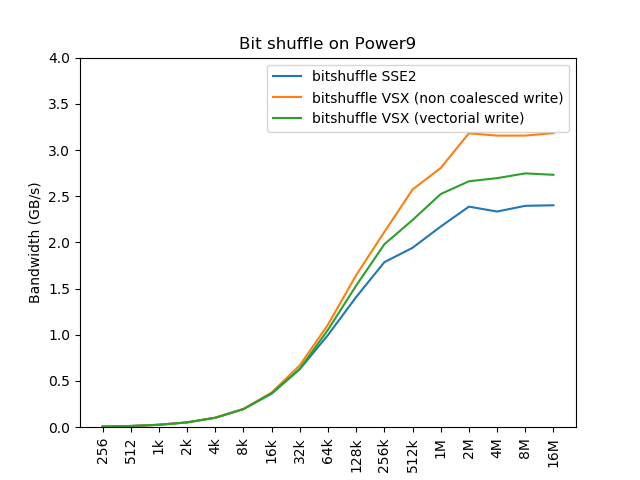

In [6]:
fig,ax = subplots()
ax.plot([i.SSE2 for i in timing_bsa.values()], label="bitshuffle SSE2")
ax.plot([i.VSX for i in timing_bsa.values()], label="bitshuffle VSX (non coalesced write)")
ax.plot([i.VSX_vec_write for i in timing_bsa.values()], label="bitshuffle VSX (vectorial write)")

ax.legend()
ax.set_title("Bit shuffle on Power9")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(timing_bsa)))
ax.set_xticklabels(list(timing_bsa.keys()), rotation='vertical')
ax.set_ylim((0, 4))
fig.savefig("bitshuffle_altivec_8bits.svg", transparent=True)

In [9]:
size = 64*1024*1024
dtype = numpy.dtype("int32")
inp = numpy.random.randint(1<<31, size=size).astype(dtype)
out = numpy.ones_like(inp)

In [10]:
def shuffle(inp, out=None, blosc=blosc2_dev):
    if out is None:
        out = numpy.empty_like(inp)
    type_size = c_int32(numpy.dtype(inp.dtype).itemsize)
    blocksize = c_int32(inp.nbytes)
    blosc.shuffle(type_size, blocksize, inp.ctypes.data, out.ctypes.data)
    return out
def unshuffle(inp, out=None, blosc=blosc2_dev):
    if out is None:
        out = numpy.empty_like(inp)
    type_size = c_int32(numpy.dtype(inp.dtype).itemsize)
    blocksize = c_int32(inp.nbytes)
    blosc.unshuffle(type_size, blocksize, inp.ctypes.data, out.ctypes.data)
    return out
assert abs(unshuffle(shuffle(inp))-inp).sum() == 0

In [10]:
%timeit unshuffle(inp, out, blosc=blosc2_dev)
%timeit unshuffle(inp, out, blosc=blosc2_ref)

The slowest run took 10.52 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 22.2 ms per loop
10 loops, best of 5: 23.8 ms per loop


In [7]:
def benchmark(sflux="shuffle_sse2", sreflux= "unshuffle_sse2",
              dtype="int32", minsize=10, maxsize=25, blosc2=blosc2_ref):
    print("Benchmarking %s and %s"%(sflux, sreflux))
    flux = blosc2.__getattr__(sflux)
    reflux = blosc2.__getattr__(sreflux)
    dtype = numpy.dtype(dtype)
    type_size = c_int32(dtype.itemsize)
    maxi = 1<<(dtype.itemsize*8-2)
    globals()["blosc2"] = blosc2
    globals()["flux"] = flux
    globals()["reflux"] = reflux
    globals()["type_size"] = type_size
    results = OrderedDict()
    dtype = numpy.dtype(dtype)
    for i in range(minsize, maxsize):
        size = 1<<i
        if i>19:
            key = "%iM"%(1<<(i-20))
        elif i>9:
            key = "%ik"%(1<<(i-10))
        else:
            key = str(size)
        npsize = size // dtype.itemsize
        print(key, size, npsize)
        if dtype.kind=="i":
            inp = numpy.random.randint(0, maxi, size=npsize).astype(dtype)
        elif dtype.kind=="c":
            inp = (numpy.random.random(size=npsize)+complex(0,1)*numpy.random.random(size=npsize)).astype(dtype)
        else:
            inp = numpy.random.random(size=npsize).astype(dtype)
        tmp = numpy.empty_like(inp)
        out = numpy.empty_like(inp)        
        blocksize = c_int32(inp.nbytes)
        flux(type_size, blocksize, inp.ctypes.data, tmp.ctypes.data)
        reflux(type_size, blocksize, tmp.ctypes.data, out.ctypes.data)
        assert abs(out-inp).sum() == 0
        continue
        
        globals()["blocksize"] = blocksize
        globals()["inp"] = inp
        globals()["tmp"] = tmp
        globals()["out"] = out
        b = %timeit -o flux(type_size, blocksize, inp.ctypes.data, tmp.ctypes.data)
        u = %timeit -o reflux(type_size, blocksize, inp.ctypes.data, tmp.ctypes.data)
        results[key] = Result(inp.nbytes/b.best/1e9, inp.nbytes/u.best/1e9)
    return results

In [8]:
shuffle_generic_16b = benchmark("shuffle_generic", "unshuffle_generic",maxsize=25, blosc2=blosc2_ref, dtype="uint16")
shuffle_sse2_16b = benchmark("shuffle_altivec", "unshuffle_altivec",maxsize=25, blosc2=blosc2_ref, dtype="uint16")
shuffle_vsx_16b = benchmark("shuffle_altivec", "unshuffle_altivec",maxsize=25, blosc2=blosc2_dev, dtype="uint16")

Benchmarking shuffle_generic and unshuffle_generic
1k 1024
10000 loops, best of 5: 39.7 µs per loop
10000 loops, best of 5: 37.3 µs per loop
2k 2048
10000 loops, best of 5: 38 µs per loop
10000 loops, best of 5: 37.8 µs per loop
4k 4096
10000 loops, best of 5: 40.2 µs per loop
10000 loops, best of 5: 38.8 µs per loop
8k 8192
10000 loops, best of 5: 39.4 µs per loop
10000 loops, best of 5: 40.4 µs per loop
16k 16384
10000 loops, best of 5: 41.8 µs per loop
10000 loops, best of 5: 43.7 µs per loop
32k 32768
10000 loops, best of 5: 46.8 µs per loop
10000 loops, best of 5: 50.8 µs per loop
64k 65536
10000 loops, best of 5: 56.6 µs per loop
The slowest run took 5.56 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 64.3 µs per loop
128k 131072
10000 loops, best of 5: 75.9 µs per loop
10000 loops, best of 5: 91.5 µs per loop
256k 262144
10000 loops, best of 5: 115 µs per loop
10000 loops, best of 5: 147 µs per loop
512k 524288

<IPython.core.display.Javascript object>


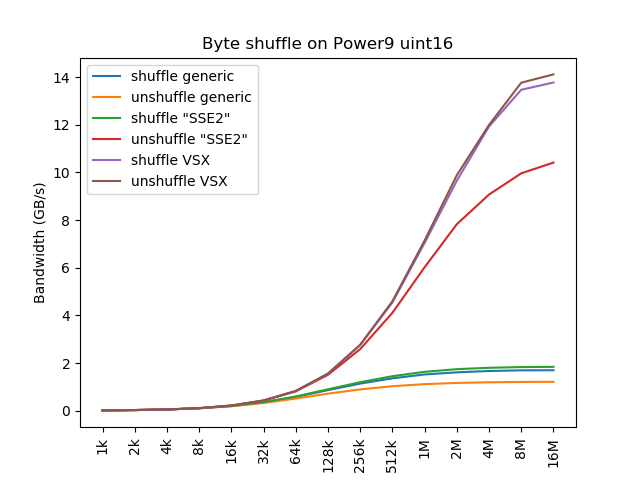

In [9]:
fig,ax = subplots()
ax.plot([i.flux for i in shuffle_generic_16b.values()], label="shuffle generic")
ax.plot([i.reflux for i in shuffle_generic_16b.values()], label="unshuffle generic")
ax.plot([i.flux for i in shuffle_sse2_16b.values()], label='shuffle "SSE2"')
ax.plot([i.reflux for i in shuffle_sse2_16b.values()], label='unshuffle "SSE2"')
ax.plot([i.flux for i in shuffle_vsx_16b.values()], label='shuffle VSX')
ax.plot([i.reflux for i in shuffle_vsx_16b.values()], label='unshuffle VSX')
ax.legend()
ax.set_title("Byte shuffle on Power9 uint16")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(shuffle_generic_16b)))
ax.set_xticklabels(list(shuffle_generic_16b.keys()), rotation='vertical')

fig.savefig("shuffle_16bits.svg", transparent=True)

In [10]:
shuffle_generic_32b = benchmark("shuffle_generic", "unshuffle_generic",maxsize=24, blosc2=blosc2_ref, dtype="float32")
shuffle_sse2_32b = benchmark("shuffle_altivec", "unshuffle_altivec",maxsize=24, blosc2=blosc2_ref, dtype="float32")
shuffle_vsx_32b = benchmark("shuffle_altivec", "unshuffle_altivec",maxsize=24, blosc2=blosc2_dev, dtype="float32")

Benchmarking shuffle_generic and unshuffle_generic
1k 1024
10000 loops, best of 5: 39.3 µs per loop
10000 loops, best of 5: 38 µs per loop
2k 2048
10000 loops, best of 5: 38 µs per loop
10000 loops, best of 5: 39.1 µs per loop
4k 4096
10000 loops, best of 5: 39.3 µs per loop
The slowest run took 6.82 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 41.5 µs per loop
8k 8192
10000 loops, best of 5: 41.6 µs per loop
The slowest run took 19.77 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 46.1 µs per loop
16k 16384
10000 loops, best of 5: 46.6 µs per loop
10000 loops, best of 5: 55.6 µs per loop
32k 32768
10000 loops, best of 5: 56.4 µs per loop
The slowest run took 4.18 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 75.3 µs per loop
64k 65536
10000 loops, best of 5: 76 µs per loop
10000

<IPython.core.display.Javascript object>


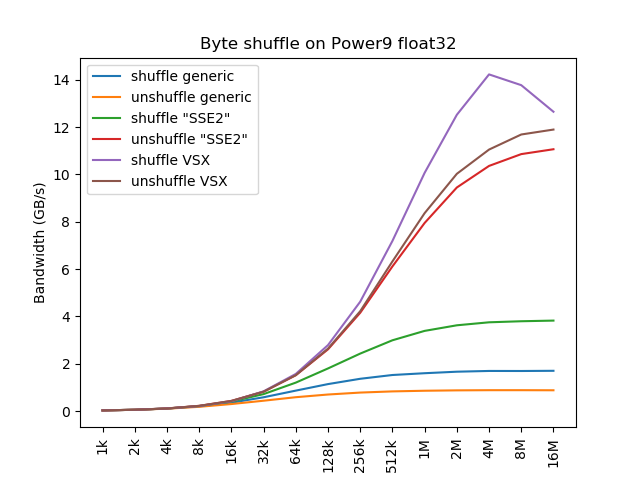

In [11]:
fig,ax = subplots()
ax.plot([i.flux for i in shuffle_generic_32b.values()], label="shuffle generic")
ax.plot([i.reflux for i in shuffle_generic_32b.values()], label="unshuffle generic")
ax.plot([i.flux for i in shuffle_sse2_32b.values()], label='shuffle "SSE2"')
ax.plot([i.reflux for i in shuffle_sse2_32b.values()], label='unshuffle "SSE2"')
ax.plot([i.flux for i in shuffle_vsx_32b.values()], label='shuffle VSX')
ax.plot([i.reflux for i in shuffle_vsx_32b.values()], label='unshuffle VSX')
ax.legend()
ax.set_title("Byte shuffle on Power9 float32")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(shuffle_generic_32b)))
ax.set_xticklabels(list(shuffle_generic_32b.keys()), rotation='vertical')

fig.savefig("shuffle_float32bits.svg", transparent=True)

In [ ]:
shuffle_generic_64b = benchmark("shuffle_generic", "unshuffle_generic", minsize=20, maxsize=22, blosc2=blosc2_ref, dtype="float64")
shuffle_sse2_64b = benchmark("shuffle_altivec", "unshuffle_altivec", minsize=20,maxsize=22, blosc2=blosc2_ref, dtype="float64")
shuffle_vsx_64b = benchmark("shuffle_altivec", "unshuffle_altivec", minsize=20,maxsize=22, blosc2=blosc2_dev, dtype="float64")

In [ ]:
fig,ax = subplots()
ax.plot([i.flux for i in shuffle_generic_64b.values()], label="shuffle generic")
ax.plot([i.reflux for i in shuffle_generic_64b.values()], label="unshuffle generic")
ax.plot([i.flux for i in shuffle_sse2_64b.values()], label='shuffle "SSE2"')
ax.plot([i.reflux for i in shuffle_sse2_64b.values()], label='unshuffle "SSE2"')
ax.plot([i.flux for i in shuffle_vsx_64b.values()], label='shuffle VSX')
ax.plot([i.reflux for i in shuffle_vsx_64b.values()], label='unshuffle VSX')
ax.legend()
ax.set_title("Byte shuffle on Power9 float64")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(shuffle_generic_64b)))
ax.set_xticklabels(list(shuffle_generic_64b.keys()), rotation='vertical')

fig.savefig("shuffle_float64.svg", transparent=True)

In [ ]:
shuffle_generic_128b = benchmark("shuffle_generic", "unshuffle_generic",maxsize=25, blosc2=blosc2_ref, dtype="complex128")
shuffle_sse2_128b = benchmark("shuffle_altivec", "unshuffle_altivec",minsize=25, blosc2=blosc2_ref, dtype="complex128")
shuffle_vsx_128b = benchmark("shuffle_altivec", "unshuffle_altivec",minsize=25, blosc2=blosc2_dev, dtype="complex128")

In [ ]:
fig,ax = subplots()
ax.plot([i.flux for i in shuffle_generic_128b.values()], label="shuffle generic")
ax.plot([i.reflux for i in shuffle_generic_128b.values()], label="unshuffle generic")
ax.plot([i.flux for i in shuffle_sse2_128b.values()], label='shuffle "SSE2"')
ax.plot([i.reflux for i in shuffle_sse2_128b.values()], label='unshuffle "SSE2"')
ax.plot([i.flux for i in shuffle_vsx_128b.values()], label='shuffle VSX')
ax.plot([i.reflux for i in shuffle_vsx_128b.values()], label='unshuffle VSX')
ax.legend()
ax.set_title("Byte shuffle on Power9 complex128")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(shuffle_generic_64b)))
ax.set_xticklabels(list(shuffle_generic_128b.keys()), rotation='vertical')

fig.savefig("shuffle_complex128.svg", transparent=True)

# Bitshuffle

In [7]:
def benchmark_bitshuffle(dtype="uint8", minsize=8, maxsize=25):
    print("Benchmarking bitshuffle from Dectris")
    results = OrderedDict()
    dtype = numpy.dtype(dtype)
    for i in range(minsize, maxsize):
        size = 1<<i
        if i>19:
            key = "%iM"%(1<<(i-20))
        elif i>9:
            key = "%ik"%(1<<(i-10))
        else:
            key = str(size)
        print(key, size)
        inp = numpy.random.randint(0, 255, size=size).astype(dtype)
        tmp = numpy.empty_like(inp)
        temp = numpy.empty_like(inp)
        out = numpy.empty_like(inp)
        
        tmp = bitshuffle.bitshuffle(inp, inp.size*2)
        out = bitshuffle.bitunshuffle(tmp, inp.size*2)
        assert abs(out-inp).sum() == 0
        
        globals()["inp"] = inp
        globals()["tmp"] = tmp
        globals()["out"] = out
        
        b = %timeit -o bitshuffle.bitshuffle(inp, inp.size*2)
        u = %timeit -o bitshuffle.bitunshuffle(tmp, inp.size*2)
        results[key] = Result(inp.nbytes/b.best/1e9, inp.nbytes/u.best/1e9)
    return results

In [8]:
timing_bs = benchmark_bitshuffle()

Benchmarking bitshuffle from Dectris
256 256


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


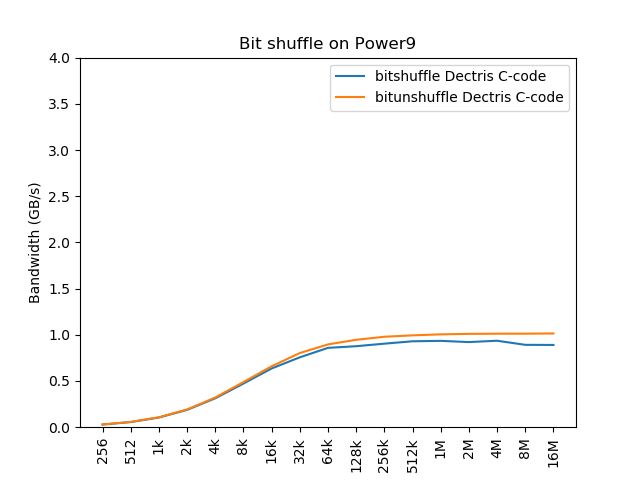

In [6]:
fig,ax = subplots()
ax.plot([i.flux for i in timing_bs.values()], label="bitshuffle Dectris C-code")
ax.plot([i.reflux for i in timing_bs.values()], label="bitunshuffle Dectris C-code")
ax.legend()
ax.set_title("Bit shuffle on Power9")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(timing_bs)))
ax.set_xticklabels(list(timing_bs.keys()), rotation='vertical')
ax.set_ylim((0, 4))
fig.savefig("bitshuffle_8bits.svg", transparent=True)

In [4]:
def benchmark_bitshuffle_altivec(dtype="uint8", minsize=8, maxsize=25):
    print("Benchmarking bitshuffle altivec")
    results = OrderedDict()
    dtype = numpy.dtype(dtype)
    for i in range(minsize, maxsize):
        size = 1<<i
        if i>19:
            key = "%iM"%(1<<(i-20))
        elif i>9:
            key = "%ik"%(1<<(i-10))
        else:
            key = str(size)
        print(key, size)
        inp = numpy.random.randint(0, 255, size=size).astype(dtype)
        tmp = numpy.empty_like(inp)
        temp = numpy.empty_like(inp)
        out = numpy.empty_like(inp)
        
        blosc2_dev.bitshuffle1_altivec(inp.ctypes.data, tmp.ctypes.data, inp.size, 1)                                                                                                                   
        f=blosc2_dev.bshuf_trans_bit_byte_altivec(inp.ctypes.data, out.ctypes.data, inp.size, 1)
        #out = bitshuffle.bitshuffle(inp, inp.size*2)
        assert abs(out-tmp).sum() == 0
        
        globals()["inp"] = inp
        globals()["tmp"] = tmp
        globals()["out"] = out
        
        b = %timeit -o blosc2_dev.bitshuffle1_altivec(inp.ctypes.data, tmp.ctypes.data, inp.size, 1)                                                                                                                  
        u = %timeit -o blosc2_dev.bshuf_trans_bit_byte_altivec(inp.ctypes.data, out.ctypes.data, inp.size, 1)
        results[key] = Result(inp.nbytes/b.best/1e9, inp.nbytes/u.best/1e9)
    return results

In [5]:
timing_bsa = benchmark_bitshuffle_altivec()

Benchmarking bitshuffle altivec
256 256
38.9 µs ± 943 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.6 µs ± 216 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
512 512
39.3 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
40 µs ± 59.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1k 1024
40.1 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.4 µs ± 861 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2k 2048
38.8 µs ± 499 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
38.8 µs ± 203 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
4k 4096
40.9 µs ± 2.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.8 µs ± 611 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
8k 8192
41.5 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
41.5 µs ± 405 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
16k 16384
43.1 µs ± 24.1 ns per loop (mea

<IPython.core.display.Javascript object>


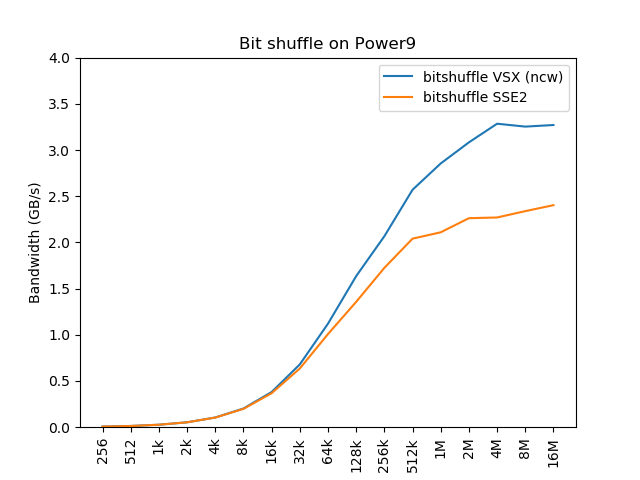

In [6]:
fig,ax = subplots()
ax.plot([i.flux for i in timing_bsa.values()], label="bitshuffle VSX (ncw)")
ax.plot([i.reflux for i in timing_bsa.values()], label="bitshuffle SSE2")
ax.legend()
ax.set_title("Bit shuffle on Power9")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(timing_bsa)))
ax.set_xticklabels(list(timing_bsa.keys()), rotation='vertical')
ax.set_ylim((0, 4))
fig.savefig("bitshuffle_altivec_8bits.svg", transparent=True)

<IPython.core.display.Javascript object>


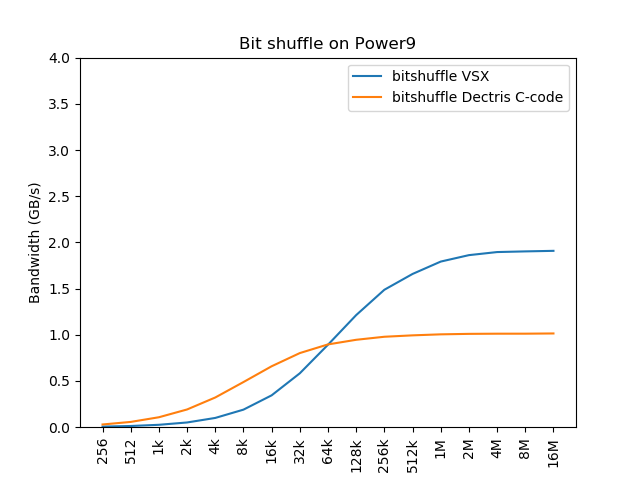

In [10]:
fig,ax = subplots()
ax.plot([i.flux for i in timing_bsa.values()], label="bitshuffle VSX")
ax.plot([i.reflux for i in timing_bs.values()], label="bitshuffle Dectris C-code")
ax.legend()
ax.set_title("Bit shuffle on Power9")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(timing_bs)))
ax.set_xticklabels(list(timing_bs.keys()), rotation='vertical')
ax.set_ylim((0, 4))
fig.savefig("bitshuffle_altivec_8bits.svg", transparent=True)

In [11]:
def benchmark_bit(sflux="bshuf_trans_bit_elem_scal", sreflux= "bshuf_untrans_bit_elem_scal", 
                  dtype="int32", minsize=8, maxsize=25, blosc2=blosc2_dev):
    print("Benchmarking bitshuffle %s and %s"%(sflux, sflux))
    if isinstance(sflux, str):
        flux = blosc2.__getattr__(sflux)
    else:
        flux = sflux
    
    if isinstance(sflux, str):
        reflux = blosc2.__getattr__(sreflux)
    else:
        reflux = sreflux
            
    type_size = c_int32(numpy.dtype(dtype).itemsize)
    globals()["blosc2"] = blosc2
    globals()["flux"] = flux
    globals()["reflux"] = reflux
    globals()["type_size"] = type_size
    results = OrderedDict()
    dtype = numpy.dtype(dtype)
    for i in range(minsize, maxsize):
        size = 1<<i
        if i>19:
            key = "%iM"%(1<<(i-20))
        elif i>9:
            key = "%ik"%(1<<(i-10))
        else:
            key = str(size)
        print(key, size)
        inp = numpy.random.randint(1<<31, size=size//4).astype(dtype)
        tmp = numpy.empty_like(inp)
        temp = numpy.empty_like(inp)
        out = numpy.empty_like(inp)
        
        blocksize = c_int32(inp.size)
        flux(inp.ctypes.data, tmp.ctypes.data,blocksize, type_size, temp.ctypes.data)
        reflux(tmp.ctypes.data, out.ctypes.data, blocksize, type_size, temp.ctypes.data)
        assert abs(out-inp).sum() == 0
        
        globals()["blocksize"] = blocksize
        globals()["inp"] = inp
        globals()["tmp"] = tmp
        globals()["temp"] = temp
        globals()["out"] = out
        
        b = %timeit -o flux(inp.ctypes.data, tmp.ctypes.data, blocksize, type_size, temp.ctypes.data)
        u = %timeit -o reflux(tmp.ctypes.data, out.ctypes.data, blocksize, type_size, temp.ctypes.data)
        results[key] = Result(inp.nbytes/b.best/1e9, inp.nbytes/u.best/1e9)
    return results

In [ ]:
results_bitshuffle_generic = benchmark_bit("bshuf_trans_bit_elem_scal", "bshuf_untrans_bit_elem_scal", blosc2=blosc2_dev)
results_bitshuffle_sse2 = benchmark_bit("bshuf_trans_bit_elem_altivec", "bshuf_untrans_bit_elem_altivec", blosc2=blosc2_dev)

In [ ]:
fig,ax = subplots()
ax.plot([i.flux for i in results_bitshuffle_generic.values()], label="bitshuffle generic")
ax.plot([i.reflux for i in results_bitshuffle_generic.values()], label="bitunshuffle generic")
ax.plot([i.flux for i in results_bitshuffle_sse2.values()], label='bitshuffle VSX')
ax.plot([i.reflux for i in results_bitshuffle_sse2.values()], label='bitunshuffle VSX')
# ax.plot([i.flux for i in results_bitshuffle_avx2.values()], label="bitshuffle AVX2")
# ax.plot([i.reflux for i in results_bitshuffle_avx2.values()], label="bitunshuffle AVX2")
ax.legend()
ax.set_title("Bit shuffle on Power9")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(results_bitshuffle_generic)))
ax.set_xticklabels(list(results_bitshuffle_generic.keys()), rotation='vertical')
ax.set_ylim((0, 4))
fig.savefig("bitshuffle_32b.svg", transparent=True)

<IPython.core.display.Javascript object>


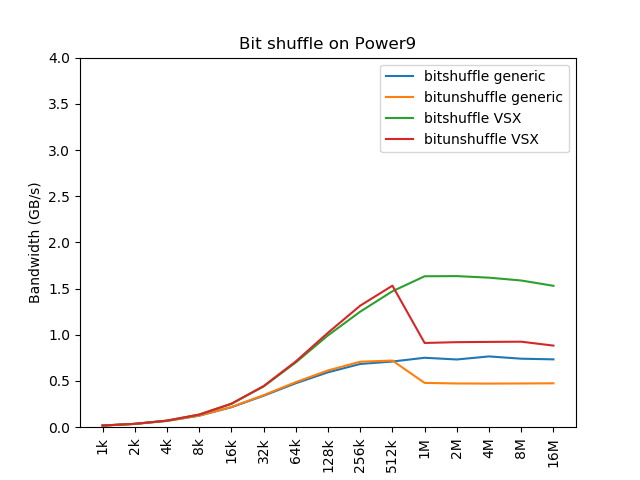

In [14]:
fig,ax = subplots()
ax.plot([i.flux for i in results_bitshuffle_generic.values()], label="bitshuffle generic")
ax.plot([i.reflux for i in results_bitshuffle_generic.values()], label="bitunshuffle generic")
ax.plot([i.flux for i in results_bitshuffle_sse2.values()], label='bitshuffle VSX')
ax.plot([i.reflux for i in results_bitshuffle_sse2.values()], label='bitunshuffle VSX')
# ax.plot([i.flux for i in results_bitshuffle_avx2.values()], label="bitshuffle AVX2")
# ax.plot([i.reflux for i in results_bitshuffle_avx2.values()], label="bitunshuffle AVX2")
ax.legend()
ax.set_title("Bit shuffle on Power9")
ax.set_ylabel("Bandwidth (GB/s)")
ax.set_xticks(numpy.arange(len(results_bitshuffle_generic)))
ax.set_xticklabels(list(results_bitshuffle_generic.keys()), rotation='vertical')
ax.set_ylim((0, 4))
fig.savefig("bitshuffle_32b.svg", transparent=True)

In [ ]:
ls


In [ ]:
#!cp shuffle.svg shuffle_p9.svg

In [ ]:
#!cp bitshuffle.svg bitshuffle_p9.svg